In [7]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bnlearn as bn

pd.options.mode.chained_assignment = None

In [15]:
'''
======================================================================================================================
FUNCTIONS
======================================================================================================================
'''

def get_first_index(raw_df, reference):

    # Calculate the time delta from the first index to the previous 5 min epoch
    first_index = 0
    first_time = pd.to_datetime(raw_df.loc[first_index, "Time"], dayfirst=True)
    delta_from_integer = (first_time - reference).total_seconds() % (60*5)

    # Find first index that is less than 30s from the start of a 5s epoch
    found_first_index = True
    while delta_from_integer > 30:
        first_index += 1
        if first_index < len(raw_df):
            first_time = pd.to_datetime(raw_df.loc[first_index, "Time"], dayfirst=True)
            delta_from_integer = (first_time - reference).total_seconds() % (60*5)
        else:
            found_first_index = False
            break
    
    return found_first_index, first_index

class BadSignalWarning(UserWarning):
    pass

def classify_glucose_level(glucose_level, segment_id_day, hour_format=False):
    
    # Convert segment_id_day to hour
    if not hour_format:
        hour = np.floor(segment_id_day/12)
    else:
        hour = segment_id_day-1
    
    # Before 2pm
    if hour < 14:
        
        # Hypoglycemic
        if glucose_level < 4:
            return 0
        # Normoglycemic
        if glucose_level < 5.5:
            return 1
        # High glucose
        if glucose_level < 7:
            return 2
        # Hyperglycemic
        else:
            return 3
    
    # After 2pm
    else:
        # Hypoglycemic
        if glucose_level < 4:
            return 0
        # Normoglycemic
        if glucose_level < 8:
            return 1
        # High glucose
        if glucose_level < 11:
            return 2
        # Hyperglycemic
        else:
            return 3
        
def get_data_count(counting_df, count_type='individual'):
    
    # If we care about individual rows, it's a matter of how many
    if count_type == 'individual':
        return len(counting_df)
    
    # Otherwise, we need to count instances where rows are adjacent
    if count_type == 'consecutive':
        counting_df = counting_df.sort_values(by=['patient_id', 'segment_id_abs'])
        segment_gaps = np.diff(np.array(counting_df['segment_id_abs']))
        return np.count_nonzero(segment_gaps == 1)
    
def infer_glucose(model, evidence, glucose_list, lo_ci=0.025, hi_ci=0.975):
    
    # Generate PDF and CDF
    query = bn.inference.fit(model, variables=['glucose'], evidence=evidence, verbose=0, to_df=False)
    pdf = query.values
    cdf = np.cumsum(pdf)
    
    # Check if uniform; if so, return unclear result
    max_diff = np.max(np.diff(pdf))
    if max_diff < 0.005:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    else:
        # Calculate 95% CI and other values
        lower = glucose_list[np.argmax(cdf>lo_ci)]
        nomin = glucose_list[np.argmax(pdf)]
        upper = glucose_list[np.argmax(cdf>hi_ci)]
        group = classify_glucose_level(nomin, evidence['hour'], hour_format=True)
        
        # Adjust for inherent uncertainty
        lower = lower - 0.1
        upper = upper + 0.1
        
        return lower, nomin, upper, group, pdf
    
def infer_glucose_on_row(model, df_row, glucose_list):
    
    # Set up basic evidence
    evidence = {'patient_id': int(df_row['patient_id']),
                'hour': int(df_row['hour'])}

    # Add heart rate evidence, if available
    if not np.isnan(df_row['hr']):
        evidence['hr'] = int(df_row['hr'])

    # Add activity evidence if available
    if not np.isnan(df_row['activity']):
        evidence['activity'] = df_row['activity']
    
    # Perform inference
    try:
        return infer_glucose(model, evidence, glucose_list)
    except IndexError:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
# df_row should have cols [patient_id, segment_id_abs, segment_id_day, hour, hr, activity, glucose, glucose_level]
def forecast_sensors(model, df_row, hr_list, activity_list, glucose_list, lo_ci=0.25, hi_ci=0.75, bound='nom'):
    
    # Set up first set of evidence
    evidence = {'patient_id': int(df_row['patient_id']),
                'hour': int(df_row['hour']),
                'hr': int(df_row['hr']),
                'activity': df_row['activity'],
                'glucose': df_row['glucose']}
    
    # Generate PDF
    pdf_hr = bn.inference.fit(model, variables=['hr_n'], evidence=evidence, verbose=0, to_df=False).values
    pdf_activity = bn.inference.fit(model, variables=['activity_n'], evidence=evidence, verbose=0, to_df=False).values
    pdf_glucose = bn.inference.fit(model, variables=['glucose_n'], evidence=evidence, verbose=0, to_df=False).values
    
    # Update elements of the row's future values
    df_row['segment_id_abs'] = df_row['segment_id_abs'] + 1
    df_row['segment_id_day'] = (df_row['segment_id_day'] + 1)%(12*24)
    df_row['hour'] = np.floor(df_row['segment_id_day']/12)+1
    
    # Check if uniform
    max_diff = np.max(np.diff(np.concatenate([pdf_hr, pdf_activity, pdf_glucose])))
    if max_diff < 0.005:
        # If so, return the row without updating sensor forecasts
        return df_row
    else:
        
        # Update based on the type of bound we want
        if bound == 'low':
            df_row['hr'] = hr_list[np.argmax(np.cumsum(pdf_hr)>lo_ci)]
            df_row['activity'] = activity_list[np.argmax(np.cumsum(pdf_activity)>lo_ci)]
            df_row['glucose'] = glucose_list[np.argmax(np.cumsum(pdf_glucose)>lo_ci)]
        if bound == 'nom':
            df_row['hr'] = hr_list[np.argmax(pdf_hr)]
            df_row['activity'] = activity_list[np.argmax(pdf_activity)]
            df_row['glucose'] = glucose_list[np.argmax(pdf_glucose)]
        if bound == 'upp':
            df_row['hr'] = hr_list[np.argmax(np.cumsum(pdf_hr)>hi_ci)]
            df_row['activity'] = activity_list[np.argmax(np.cumsum(pdf_activity)>hi_ci)]
            df_row['glucose'] = glucose_list[np.argmax(np.cumsum(pdf_glucose)>hi_ci)]
        
        df_row['glucose_level'] = classify_glucose_level(df_row['glucose'], df_row['hour'], hour_format=True)
        
        return df_row
    
def forecast_n_steps(model, df_row, hr_list, activity_list, glucose_list, steps=6, bound='nom'):
    
    forecast_df = None
    for step in range(steps):
        # Get the new row
        new_row = forecast_sensors(model, df_row, hr_list, activity_list, glucose_list, bound=bound)
        
        # Append the row
        if step == 0:
            forecast_df = pd.DataFrame([df_row, new_row])
        else:
            forecast_df = forecast_df.append(new_row, ignore_index=True)
        df_row = new_row.copy()
        
    return forecast_df

In [3]:
'''
======================================================================================================================
PROCESS SENSOR DATA
======================================================================================================================
'''

# Set filepath for data
fpath = "/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/02 - Core Research/05 - Wearables for Chronic Diseases/02 - Datasets/D1NAMO/diabetes_subset_sensor_data"

# Set reference start point
reference_time = pd.Timestamp(2014, 10, 1, 0)

# Create dataframe
cols = ["patient_id", "segment_id_abs", "segment_id_day", "day", "hr", "activity", "hr_u", "activity_u"]
sensor_statistics = pd.DataFrame(columns=cols)

# Generate a list of all files for a patient
patients = ['001', '002', '003', '004', '005', '006', '007', '008', '009']
for patient in patients:
    filelist = []
    for root, dirs, files in os.walk(fpath + "/" + patient):
        for file in files:
            if(file.endswith("Summary.csv")):
                filelist.append(os.path.join(root,file))
                
    # Read and process sensor file
    for filename in filelist:
        sensor_data = pd.read_csv(filename)
        
        # Verify sample rate is adequate
        first_time = pd.to_datetime(sensor_data.loc[0,'Time'], dayfirst=True)
        last_time = pd.to_datetime(sensor_data.loc[len(sensor_data)-1,'Time'], dayfirst=True)
        seconds_covered = (last_time - first_time).total_seconds()
        if seconds_covered != (len(sensor_data)-1):
            print("Sampling error: " + filename)
            print()
            
        # Trim initial component of signal
        found_first_index, first_index = get_first_index(sensor_data, reference_time)
        if not found_first_index:
            print("Signal not long enough to provide index: " + filename)
            print()
            break
        else:
            sensor_data = sensor_data[first_index:]
            
        # Calculate the number of samples in a segment and how many segments there are
        segment_size = 60*5
        n_segments = int(np.floor(len(sensor_data)/segment_size))
        
        # Sift through the sensor readings
        file_statistics = pd.DataFrame(columns=cols)
        for i in range(n_segments):

            # Get current segment
            current_segment = sensor_data[i*segment_size:(i+1)*segment_size]
            
            # Process heart rate data, ignoring areas where HR is zero
            segment_hr = np.asarray(current_segment[current_segment['HR'] != 0]['HR'])
            hr_mean = np.nan
            if len(segment_hr) > 0:
                hr_mean = np.mean(segment_hr)
                
            # Process activity data
            activity_mean = np.mean(np.asarray(current_segment['Activity']))
            
            # Get the time IDs of the current segment
            segment_time = pd.to_datetime(current_segment["Time"].iloc[5], dayfirst=True)
            sec_since_reference = (segment_time - reference_time).total_seconds()
            sec_since_midnight = sec_since_reference % (60*60*24)
            segment_id_abs = int(np.floor( sec_since_reference / (60*5)))
            segment_id_day = int(np.floor( sec_since_midnight / (60*5)))
            day = int(np.floor(sec_since_reference / (60*60*24)) + 1)
            
            # Add sensor statistics to dataframe
            segment_data = {'patient_id': patient,
                            'segment_id_abs': segment_id_abs,
                            'segment_id_day': segment_id_day,
                            'day': day,
                            'hr': hr_mean,
                            'activity': activity_mean,
                            'hr_u': hr_mean,
                            'activity_u': activity_mean}
            file_statistics = file_statistics.append(segment_data, ignore_index = True)
            
        # Conduct post processing across segments
        file_statistics['hr'] = np.around(file_statistics['hr'].rolling(5).mean()/2)*2
        file_statistics['activity'] = np.around(file_statistics['activity'].rolling(9).mean(), 2)
        file_statistics['hr_u'] = file_statistics['hr_u'].rolling(5).mean()
        file_statistics['activity_u'] = file_statistics['activity_u'].rolling(9).mean()
        
        sensor_statistics = pd.concat([sensor_statistics, file_statistics])
        
# Save processed sensor data
savepath = "/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/03 - Coursework/COMP 588/Project/02 - Code"
sensor_statistics.to_csv(savepath + "/sensor_statistics.csv", index=False)

In [41]:
'''
======================================================================================================================
PROCESS GLUCOSE SIGNAL
======================================================================================================================
'''

# Set file path
fpath = "/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/02 - Core Research/05 - Wearables for Chronic Diseases/02 - Datasets/D1NAMO/diabetes_subset_pictures-glucose-food-insulin"

# Set reference start point
reference_time = pd.Timestamp(2014, 10, 1, 0)

# Create dataframe
cols = ["patient_id", "segment_id_abs", "segment_id_day", "day", "glucose", "glucose_level"]
patient_statistics = pd.DataFrame(columns=cols)

# Generate a list of all files for a patient
patients = ['001', '002', '003', '004', '005', '006', '007', '008', '009']
for patient in patients:
    
    # Read and process each glucose file
    raw_glucose = pd.read_csv(fpath + "/" + patient + "/glucose.csv")
    
    # Go through rows and parse glucose readings
    for row in range(len(raw_glucose)):

        # Get the time IDs of the current segment
        segment_time = pd.to_datetime(raw_glucose.loc[row,'date'] + ' ' + raw_glucose.loc[row,'time'])
        sec_since_reference = (segment_time - reference_time).total_seconds()
        sec_since_midnight = sec_since_reference % (60*60*24)
        segment_id_abs = int(np.floor( sec_since_reference / (60*5)))
        segment_id_day = int(np.floor( sec_since_midnight / (60*5)))
        day = int(np.floor(sec_since_reference / (60*60*24)) + 1)

        # Verify we are recording within the experiment and add to dataframe
        if day > 0 and day < 5:
            segment_data = {'patient_id': patient,
                            'segment_id_abs': segment_id_abs,
                            'segment_id_day': segment_id_day,
                            'day': day,
                            'glucose': np.around(raw_glucose.loc[row,'glucose'], 1),
                            'glucose_level': classify_glucose_level(raw_glucose.loc[row,'glucose'], segment_id_day)}
            patient_statistics = patient_statistics.append(segment_data, ignore_index = True)
    
    # Remove instances where there are two readings in a time segment
    duplicated_ids = np.where(patient_statistics.duplicated(subset=['patient_id','segment_id_abs']) == True)[0]
    if len(duplicated_ids) > 0:
        for dup_id in duplicated_ids:
            glucose_average = np.mean(np.array([patient_statistics.loc[dup_id-1,"glucose"],
                                                patient_statistics.loc[dup_id,"glucose"]]))
            patient_statistics.loc[dup_id-1,"glucose"] = np.around(glucose_average, 1)
            patient_statistics = patient_statistics.drop(index=dup_id)
        
    # Reset index
    patient_statistics = patient_statistics.reset_index(drop=True)
            
# Save processed glucose data
savepath = "/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/03 - Coursework/COMP 588/Project/02 - Code"
patient_statistics.to_csv(savepath + "/glucose_statistics.csv", index=False)

In [4]:
'''
======================================================================================================================
POST PROCESS PATIENT STATS
======================================================================================================================
'''

# Set directory
savepath = "/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/03 - Coursework/COMP 588/Project/02 - Code"

# Load processed sensor statistics
sensor_stats = pd.read_csv(savepath + "/sensor_statistics.csv")

# Load processed glucose statistics
glucose_stats = pd.read_csv(savepath + "/glucose_statistics.csv")

# Merge dataframes to get patient statistics
patient_stats = pd.merge(sensor_stats, glucose_stats,  how='outer',
                         on=['patient_id','segment_id_abs','segment_id_day','day'])

# Save joint data
patient_stats.to_csv(savepath + "/patient_statistics.csv", index=False)

In [176]:
'''
======================================================================================================================
PHASE ONE MODEL
======================================================================================================================
'''

# Working folder
savepath = "/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/03 - Coursework/COMP 588/Project/02 - Code"

# Load processed sensor statistics
patient_stats = pd.read_csv(savepath + "/patient_statistics.csv")

# Add a feature to annotate hour in the day
patient_stats['hour'] = np.floor(patient_stats['segment_id_day']/12) + 1

# Round glucose values to nearest 0.2
patient_stats['glucose_u'] = patient_stats['glucose']
patient_stats['glucose'] = np.around(patient_stats['glucose']/0.2)*0.2

# Drop rows with everything as nan and re-index
patient_stats = patient_stats.dropna(subset=['hr', 'activity', 'glucose', 'glucose_level'], how='all')
patient_stats = patient_stats.reset_index(drop=True)
print("Available timestamps: " + str(len(patient_stats)))
print("Hours in Day: " + str(len(np.unique(np.array(patient_stats['hour'])))))
print("HR Variables: " + str(len(np.unique(np.array(patient_stats['hr'])))))
print("Activity Variables: " + str(len(np.unique(np.array(patient_stats['activity'])))))
print("Glucose Variables: " + str(len(np.unique(np.array(patient_stats['glucose'])))))
print()

# Drop rows with anything as nan
bn_subset = patient_stats.dropna()
print("Available timestamps: " + str(len(bn_subset)))
print("Hours in Day: " + str(len(np.unique(np.array(bn_subset['hour'])))))
print("HR Variables: " + str(len(np.unique(np.array(bn_subset['hr'])))))
print("Activity Variables: " + str(len(np.unique(np.array(bn_subset['activity'])))))
print("Glucose Variables: " + str(len(np.unique(np.array(bn_subset['glucose'])))))
print()

# Print example of data
print(bn_subset.drop(columns=['segment_id_abs', 'segment_id_day', 'hr_u', 'activity_u', 'glucose_u']))

# Select variables for model
bn_subset = bn_subset[['patient_id', 'hour', 'hr', 'activity', 'glucose', 'glucose_level']]

# Save example of glucose level options
glucose_list = np.unique(bn_subset['glucose'])

# Learn model parameters
edges = [('hour', 'hr'),
         ('hour', 'activity'),
         ('hour', 'glucose'),
         ('patient_id', 'hr'),
         ('patient_id', 'activity'),
         ('patient_id', 'glucose'),
         ('hr', 'glucose'),
         ('activity', 'glucose'),
         ('glucose', 'glucose_level')]
DAG = bn.make_DAG(edges)
bn.plot(DAG)
DAG = bn.parameter_learning.fit(DAG, bn_subset, methodtype='bayes')

# Save model
bn.save(DAG, filepath=savepath + '/phase_one_model', overwrite=True)

# Load models
DAG = bn.load(filepath=savepath + '/bnlearn_model')

Available timestamps: 8183
Hours in Day: 24
HR Variables: 74
Activity Variables: 31
Glucose Variables: 102

Available timestamps: 2801
Hours in Day: 23
HR Variables: 72
Activity Variables: 30
Glucose Variables: 95

      patient_id  day    hr  activity  glucose  glucose_level  hour
104            1    1  68.0      0.02     10.4            3.0  20.0
105            1    1  70.0      0.03     10.0            3.0  20.0
106            1    1  70.0      0.03      9.6            3.0  20.0
107            1    1  74.0      0.04      9.6            3.0  20.0
108            1    1  80.0      0.05      9.4            3.0  20.0
...          ...  ...   ...       ...      ...            ...   ...
4342           9    3  46.0      0.14      4.8            1.0  13.0
4343           9    3  46.0      0.14      4.2            1.0  13.0
4344           9    3  48.0      0.14      3.2            0.0  13.0
4345           9    3  46.0      0.14      2.8            0.0  13.0
4346           9    3  44.0      0.15

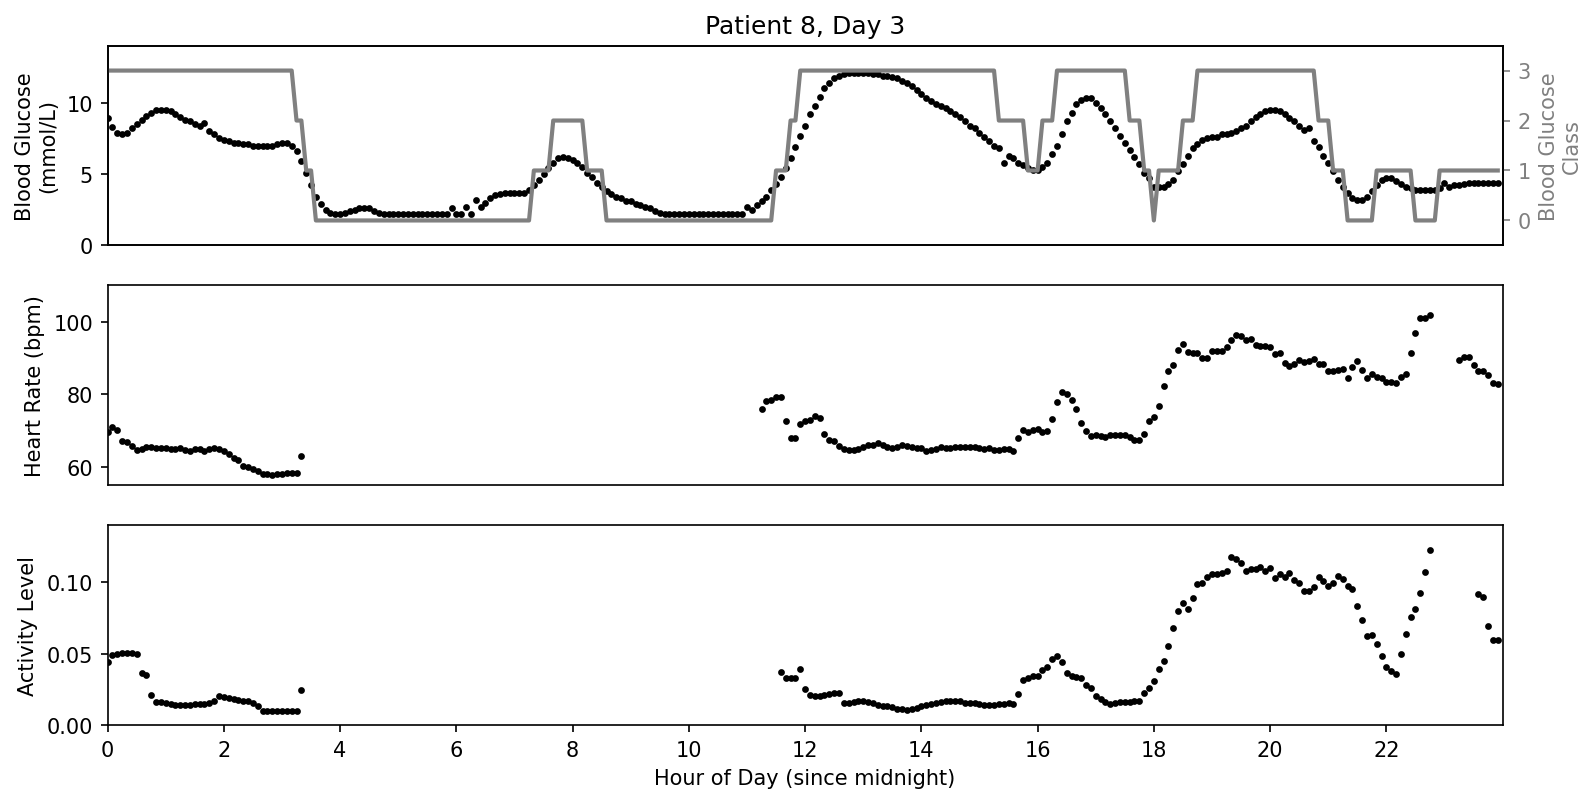

In [25]:
'''
======================================================================================================================
FIGURE ONE: PLOTTING
======================================================================================================================
'''

# Get desired patient and day
daily_data = patient_stats[(patient_stats['patient_id'] == 8) & (patient_stats['day'] == 3)]
daily_data = daily_data.sort_values(by=['segment_id_day'])
daily_data = daily_data.reset_index(drop=True)

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(12,6), dpi=150)

ax = axes[0]
ax.scatter(daily_data['segment_id_day']/12, daily_data['glucose_u'], s=5, c='k')
ax.set_ylim([0,14])
ax.set_xlim([0,24])
ax.set_xticks([])
ax.set_ylabel("Blood Glucose\n(mmol/L)")
ax.set_title("Patient 8, Day 3")

ax2 = ax.twinx()
ax2.plot(daily_data['segment_id_day']/12, daily_data['glucose_level'], color='grey', lw=2)
ax2.set_ylim([-0.5,3.5])
ax2.tick_params(axis='y', colors='grey')
ax2.set_ylabel('Blood Glucose\nClass', color='grey')

ax = axes[1]
ax.scatter(daily_data['segment_id_day']/12, daily_data['hr_u'], s=5, c='k')
ax.set_ylim([55,110])
ax.set_xlim([0,24])
ax.set_xticks([])
ax.set_ylabel("Heart Rate (bpm)")

ax = axes[2]
ax.scatter(daily_data['segment_id_day']/12, daily_data['activity_u'], s=5, c='k')
ax.set_ylim([0,0.14])
ax.set_xlim([0,24])
ax.xaxis.set_ticks(np.arange(0, 24, 2))
ax.set_xlabel('Hour of Day (since midnight)')
ax.set_ylabel("Activity Level")

plt.show()

In [68]:
'''
======================================================================================================================
FIGURE THREE: DATA GENERATION
======================================================================================================================
'''

# Load model
DAG = bn.load(filepath=savepath + '/Working Model/phase_one_model')

# Get desired patient and day
daily_data = patient_stats[(patient_stats['patient_id'] == 8) & (patient_stats['day'] == 3)]
daily_data = daily_data.sort_values(by=['segment_id_day'])
daily_data = daily_data.reset_index(drop=True)

# Infer glucose levels across dataframe
for row in range(len(daily_data)):
    if (row >= 0):
        df_row = daily_data.loc[row]
        lower, nomin, upper, group, pdf = infer_glucose_on_row(DAG, df_row, glucose_list)
        daily_data.loc[row, 'glucose_p_lower'] = lower
        daily_data.loc[row, 'glucose_p_nomin'] = nomin
        daily_data.loc[row, 'glucose_p_upper'] = upper
        daily_data.loc[row, 'glucose_p_level'] = group
        print("Row " + str(row) + " of " + str(len(daily_data)) + ": " + str(nomin))

# Save to csv
daily_data.to_csv(savepath + "/patient_eight_day_three.csv", index=False)

[pypickle] Pickle file loaded: [/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/03 - Coursework/COMP 588/Project/02 - Code/Working Model/phase_one_model.pkl]


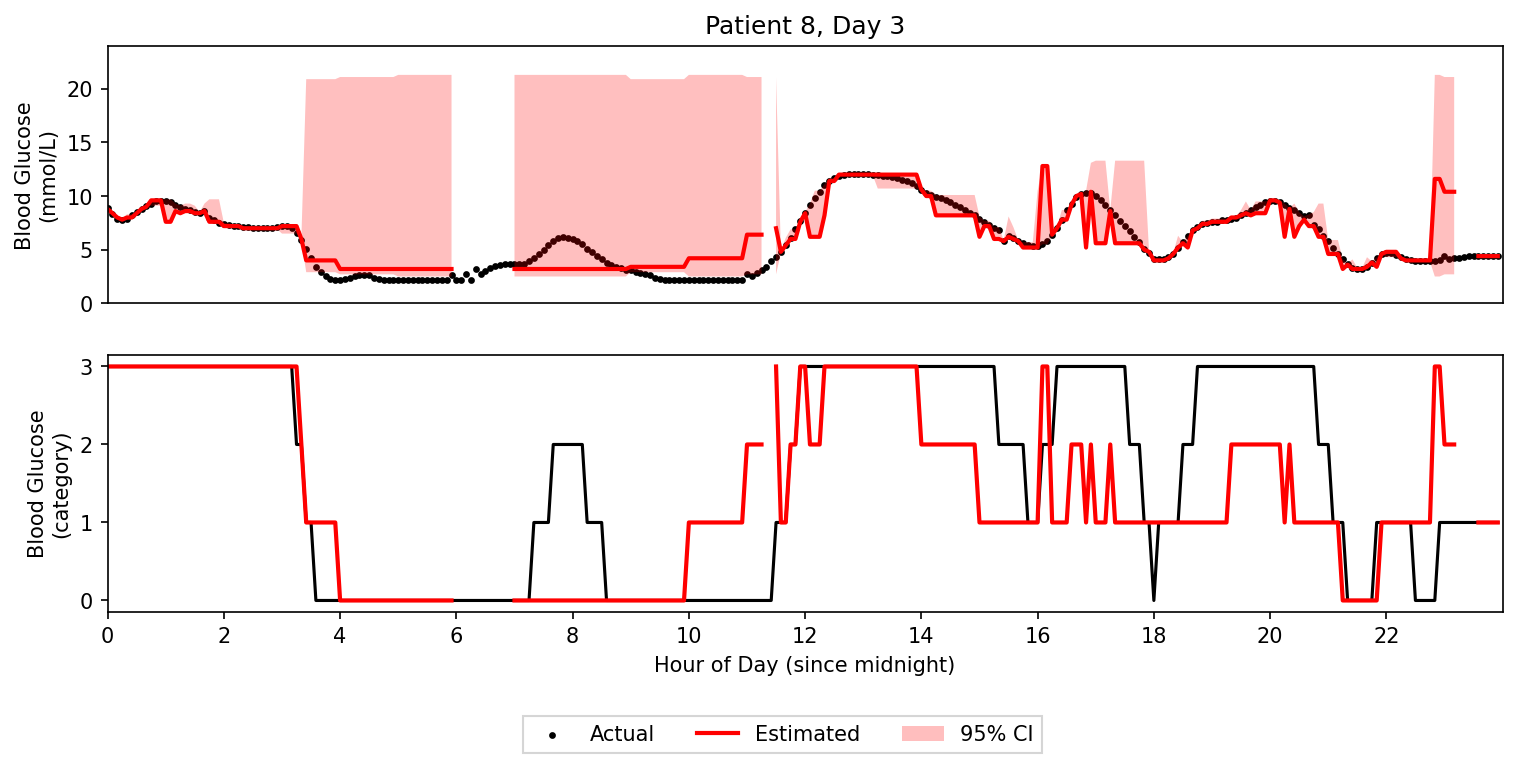

In [177]:
'''
======================================================================================================================
FIGURE THREE: PLOTTING
======================================================================================================================
'''

# Load processed data for patient 8, day 3
savepath = "/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/03 - Coursework/COMP 588/Project/02 - Code"
daily_data = pd.read_csv(savepath + "/Results/patient_eight_day_three_complete.csv")

# Create plot
fig, axes = plt.subplots(2, 1, figsize=(12,5), dpi=150)

ax = axes[0]
ax.scatter(daily_data['segment_id_day']/12, daily_data['glucose_u'], s=5, color='k', label="Actual")
ax.plot(daily_data['segment_id_day']/12, daily_data['glucose_p_nomin'], color='red', lw=2, label="Estimated")
ax.fill_between(daily_data['segment_id_day']/12, daily_data['glucose_p_lower'], daily_data['glucose_p_upper'],
                color='red', alpha=0.25, lw=0, label="95% CI")
ax.set_ylim([0,24])
ax.set_xlim([0,24])
ax.set_xticks([])
ax.set_ylabel("Blood Glucose\n(mmol/L)")
ax.set_title("Patient 8, Day 3")

ax = axes[1]
ax.plot(daily_data['segment_id_day']/12, daily_data['glucose_level'], color='k')
ax.plot(daily_data['segment_id_day']/12, daily_data['glucose_p_level'], color='red', lw=2)
ax.set_xlim([0,24])
ax.xaxis.set_ticks(np.arange(0, 24, 2))
ax.set_xlabel('Hour of Day (since midnight)')
ax.set_ylabel("Blood Glucose\n(category)")

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=False, ncol=3, shadow=False)
plt.show()

In [195]:
'''
======================================================================================================================
FIGURE THREE: ANALYSIS
======================================================================================================================
'''

print(len(daily_data))
print()

subset_with_sensor = daily_data.dropna(subset=['hr', 'activity'], how='any')
ci_with_sensor = subset_with_sensor['glucose_p_upper'] - subset_with_sensor['glucose_p_lower']
print(len(subset_with_sensor))
print(np.mean(ci_with_sensor))
print(np.std(ci_with_sensor))
print(np.max(ci_with_sensor))
print()

subset_without_sensor = daily_data[(daily_data['hr'].isna()) | (daily_data['activity'].isna())]
ci_without_sensor = subset_without_sensor['glucose_p_upper'] - subset_without_sensor['glucose_p_lower']
print(len(subset_without_sensor))
print(np.mean(ci_without_sensor))
print(np.std(ci_without_sensor))
print(np.max(ci_without_sensor))
print()

288

181
1.351381215469613
1.9631581202111585
8.4

107
18.53932584269663
0.3234706375810622
18.8



In [14]:
'''
======================================================================================================================
TABLE TWO DATA GENERATION
======================================================================================================================
'''

# Load model
DAG = bn.load(filepath=savepath + '/Working Model/phase_one_model')

# Randomly select 200 datapoints from the table
eval_subset = patient_stats.dropna(subset=['glucose'])
eval_subset = eval_subset.iloc[np.random.randint(len(eval_subset), size=200)]
eval_subset = eval_subset.reset_index(drop=True)

# Infer glucose levels across dataframe
for row in range(len(eval_subset)):
    if row >= 0:
        df_row = eval_subset.loc[row]
        lower, nomin, upper, group, pdf = infer_glucose_on_row(DAG, df_row, glucose_list)
        eval_subset.loc[row, 'glucose_p_lower'] = lower
        eval_subset.loc[row, 'glucose_p_nomin'] = nomin
        eval_subset.loc[row, 'glucose_p_upper'] = upper
        eval_subset.loc[row, 'glucose_p_level'] = group
        print("Row " + str(row) + " of " + str(len(eval_subset)) + ": " + str(nomin))

# Save to csv
eval_subset.to_csv(savepath + "/bn_evaluation_set.csv", index=False)

[pypickle] Pickle file loaded: [/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/03 - Coursework/COMP 588/Project/02 - Code/Working Model/phase_one_model.pkl]
Row 0 of 200: 9.4
Row 1 of 200: nan
Row 2 of 200: nan
Row 3 of 200: nan
Row 4 of 200: nan
Row 5 of 200: 10.600000000000001
Row 6 of 200: nan
Row 7 of 200: 3.4000000000000004
Row 8 of 200: nan
Row 9 of 200: 5.6000000000000005
Row 10 of 200: nan
Row 11 of 200: nan
Row 12 of 200: 11.200000000000001
Row 13 of 200: 10.0
Row 14 of 200: 7.4
Row 15 of 200: 7.6000000000000005
Row 16 of 200: 22.200000000000003
Row 17 of 200: 8.0
Row 18 of 200: 5.2
Row 19 of 200: nan
Row 20 of 200: nan
Row 21 of 200: nan
Row 22 of 200: 22.200000000000003
Row 23 of 200: nan
Row 24 of 200: 22.200000000000003
Row 25 of 200: nan
Row 26 of 200: nan
Row 27 of 200: 9.4
Row 28 of 200: 3.4000000000000004
Row 29 of 200: 4.0
Row 30 of 200: 8.0
Row 31 of 200: 18.400000000000002
Row 32 of 200: nan
Row 33 of 200: 4.2
Row 34 of 200: 2.8000000000000003
Row 35 o

In [211]:
'''
======================================================================================================================
TABLE TWO: ANALYSIS
======================================================================================================================
'''

# Load evaluation results
savepath = "/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/03 - Coursework/COMP 588/Project/02 - Code"
eval_subset = pd.read_csv(savepath + "/Results/bn_evaluation_set.csv")

# Calculate elements without HR or activity
print(200 - len(daily_data.dropna(subset=['hr', 'activity'], how='any')))
print()

# Drop nans
eval_subset = eval_subset.dropna(subset=['glucose_p_nomin'])

# Calculate RMSE and MAPE
errors = eval_subset['glucose_p_nomin']*18 - eval_subset['glucose']*18
rmse = np.sqrt(np.mean(errors**2))
mape = np.mean(np.abs(errors)/(eval_subset['glucose']*18))
print(rmse)
print(mape)

# Calculate accuracy
eval_subset = eval_subset.dropna(subset=['glucose_p_nomin'])
errors = np.where(eval_subset['glucose_p_level'] != eval_subset['glucose_level'])
acc = 1 - len(errors[0])/len(eval_subset)
print(acc)

19

59.37813911074781
0.23295928315378153
0.5531914893617021


In [42]:
'''
======================================================================================================================
PHASE TWO MODEL
======================================================================================================================
'''

# Working folder
savepath = "/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/03 - Coursework/COMP 588/Project/02 - Code"

# Load processed sensor statistics
dbn_patient_stats = pd.read_csv(savepath + "/patient_statistics.csv")

# Add a feature to annotate hour in the day
dbn_patient_stats['hour'] = np.floor(dbn_patient_stats['segment_id_day']/12) + 1

# Round glucose values to nearest 0.2
dbn_patient_stats['glucose_u'] = dbn_patient_stats['glucose']
dbn_patient_stats['glucose'] = np.around(dbn_patient_stats['glucose']/0.2)*0.2

# Drop rows with anything as nan
dbn_patient_stats = dbn_patient_stats.dropna()
print("Available timestamps: " + str(len(dbn_patient_stats)))
print("Hours in Day: " + str(len(np.unique(np.array(dbn_patient_stats['hour'])))))
print("HR Variables: " + str(len(np.unique(np.array(dbn_patient_stats['hr'])))))
print("Activity Variables: " + str(len(np.unique(np.array(dbn_patient_stats['activity'])))))
print("Glucose Variables: " + str(len(np.unique(np.array(dbn_patient_stats['glucose'])))))
print()

# Sort dataframe, re-index, and create second timeslice for DBN
cols_to_include_next = ['patient_id', 'segment_id_day', 'hour', 'hr', 'hr_u', 'activity', 'activity_u', 'glucose',
                        'glucose_u', 'glucose_level']
dbn_patient_stats = dbn_patient_stats.sort_values(by=['patient_id', 'segment_id_abs'])
dbn_patient_stats = dbn_patient_stats.reset_index(drop=True)
for row in range(len(dbn_patient_stats)):
    
    # Check if we have next datapoint
    if row+1 < len(dbn_patient_stats):
        if dbn_patient_stats.loc[row,'segment_id_abs'] + 1 == dbn_patient_stats.loc[row+1,'segment_id_abs']:
            if dbn_patient_stats.loc[row,'patient_id'] == dbn_patient_stats.loc[row+1,'patient_id']:

                # Copy over data
                for col in cols_to_include_next:
                    dbn_patient_stats.loc[row,col+'_n'] = dbn_patient_stats.loc[row+1,col]
                    
# Drop rows which did not have a consecutive time slice
dbn_patient_stats = dbn_patient_stats.dropna()
print("Available timestamps: " + str(len(dbn_patient_stats)))
print("Hours in Day: " + str(len(np.unique(np.array(dbn_patient_stats['hour'])))))
print("HR Variables: " + str(len(np.unique(np.array(dbn_patient_stats['hr'])))))
print("Activity Variables: " + str(len(np.unique(np.array(dbn_patient_stats['activity'])))))
print("Glucose Variables: " + str(len(np.unique(np.array(dbn_patient_stats['glucose'])))))
print()
                
# Select variables for model
dbn_subset = dbn_patient_stats[['patient_id', 'hour', 'hr', 'activity', 'glucose', 'glucose_level',
                                'hr_n', 'activity_n', 'glucose_n', 'glucose_level_n']]

# Save example of glucose level options
hr_list = np.unique(bn_subset['hr'])
activity_list = np.unique(bn_subset['activity'])
glucose_list = np.unique(bn_subset['glucose'])

# Learn model parameters
edges = [('hour', 'hr'),
         ('hour', 'activity'),
         ('hour', 'glucose'),
         ('patient_id', 'hr'),
         ('patient_id', 'activity'),
         ('patient_id', 'glucose'),
         ('hr', 'glucose'),
         ('activity', 'glucose'),
         ('glucose', 'glucose_level'),
         ('hr_n', 'glucose_n'),
         ('activity_n', 'glucose_n'),
         ('glucose_n', 'glucose_level_n'),
         ('hr', 'hr_n'),
         ('activity', 'activity_n'),
         ('glucose', 'glucose_n')]
dbnDAG = bn.make_DAG(edges)
bn.plot(dbnDAG)
dbnDAG = bn.parameter_learning.fit(dbnDAG, dbn_subset, methodtype='bayes')

# Save model
bn.save(dbnDAG, filepath=savepath + '/phase_two_model', overwrite=True)

# Load model
dbnDAG = bn.load(filepath=savepath + '/phase_two_model')

Available timestamps: 2801
Hours in Day: 23
HR Variables: 72
Activity Variables: 30
Glucose Variables: 95

Available timestamps: 2735
Hours in Day: 23
HR Variables: 72
Activity Variables: 30
Glucose Variables: 95



In [173]:
'''
======================================================================================================================
FIGURE FOUR: DATA GENERATION
======================================================================================================================
'''

# Load model
dbnDAG = bn.load(filepath=savepath + '/Working Model/phase_two_model')

# Generate a subset of the dataframe
forecast_df = dbn_patient_stats[['patient_id', 'segment_id_abs', 'segment_id_day', 'hour', 'hr', 'activity',
                                 'glucose', 'glucose_level']]

# # Perform forecast for first start point
# forecast_start = forecast_df[(forecast_df['patient_id']==7) & (forecast_df['segment_id_abs']==1046)]
# lower = forecast_n_steps(dbnDAG, forecast_start.iloc[0], hr_list, activity_list, glucose_list, steps=12, bound='low')
# nomin = forecast_n_steps(dbnDAG, forecast_start.iloc[0], hr_list, activity_list, glucose_list, steps=12, bound='nom')
# upper = forecast_n_steps(dbnDAG, forecast_start.iloc[0], hr_list, activity_list, glucose_list, steps=12, bound='upp')

# # Save to csv
# lower.to_csv(savepath + "/Results/patient_seven_id_1046_lower.csv", index=False)
# nomin.to_csv(savepath + "/Results/patient_seven_id_1046_nomin.csv", index=False)
# upper.to_csv(savepath + "/Results/patient_seven_id_1046_upper.csv", index=False)

[pypickle] Pickle file loaded: [/Users/nathanduarte/Documents/06 - McGill and McCall MacBain/03 - Coursework/COMP 588/Project/02 - Code/Working Model/phase_two_model.pkl]


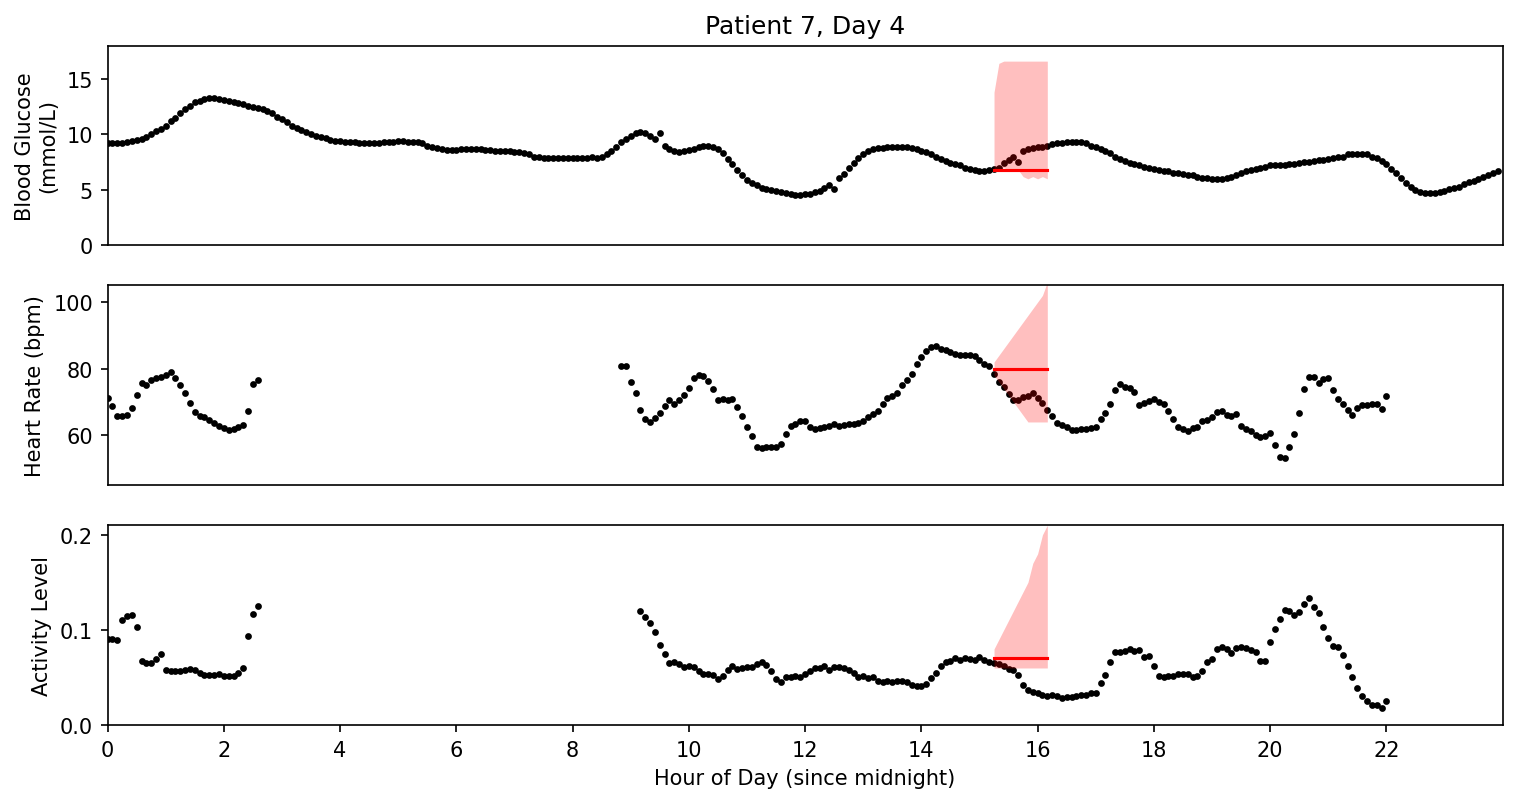

In [175]:
'''
======================================================================================================================
FIGURE FOUR: PLOTTING
======================================================================================================================
'''

# Load statistics
lower = pd.read_csv(savepath + "/Results/patient_seven_id_1046_lower.csv")
nomin = pd.read_csv(savepath + "/Results/patient_seven_id_1046_nomin.csv")
upper = pd.read_csv(savepath + "/Results/patient_seven_id_1046_upper.csv")

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(12,6), dpi=150)

ax = axes[0]
ax.scatter(daily_data['segment_id_day']/12, daily_data['glucose_u'], s=5, color='k')
ax.plot(nomin['segment_id_day']/12, nomin['glucose'], color='red')
ax.fill_between(nomin['segment_id_day']/12, lower['glucose'], upper['glucose'], color='red', alpha=0.25, lw=0)
ax.set_ylim([0,18])
ax.set_xlim([0,24])
ax.set_xticks([])
ax.set_ylabel("Blood Glucose\n(mmol/L)")
ax.set_title("Patient 7, Day 4")

ax = axes[1]
ax.scatter(daily_data['segment_id_day']/12, daily_data['hr_u'], s=5, color='k')
ax.plot(nomin['segment_id_day']/12, nomin['hr'], color='red')
ax.fill_between(nomin['segment_id_day']/12, lower['hr'], upper['hr'], color='red', alpha=0.25, lw=0)
ax.set_ylim([45,105])
ax.set_xlim([0,24])
ax.set_xticks([])
ax.set_ylabel("Heart Rate (bpm)")

ax = axes[2]
ax.scatter(daily_data['segment_id_day']/12, daily_data['activity_u'], s=5, color='k')
ax.plot(nomin['segment_id_day']/12, nomin['activity'], color='red')
ax.fill_between(nomin['segment_id_day']/12, lower['activity'], upper['activity'], color='red', alpha=0.25, lw=0)
ax.set_ylim([0,0.21])
ax.set_xlim([0,24])
ax.xaxis.set_ticks(np.arange(0, 24, 2))
ax.set_xlabel('Hour of Day (since midnight)')
ax.set_ylabel("Activity Level")

plt.show()